# 300w_lp

In [1]:
from skimage.io import imread
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import multiprocessing as mp

import os, glob, json
from TFRHelper import *
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d

In [2]:
img_size = 192
mean_avg_top_diff_ratio = 0.2963
mean_avg_bottom_diff_ratio = 0.041

swap_indices = [
    [0, 16], [1, 15], [2, 14], [3, 13], [4, 12], [5, 11], [6, 10], [7, 9], # jaw
    [17, 26], [18, 25], [19, 24], [20, 23], [21, 22], # eyebrows
    [31, 35], [32, 34], # nose
    [36, 45], [37, 44], [38, 43], [39, 42], [40, 47], [41, 46], # eyes
    [48, 54], [49, 53], [50, 52], [55, 59], [56, 58], # lips outer
    [60, 64], [61, 63], [65, 67] # lips inner
]

data_path = '../../../data-archive/facial_landmarks/300W_LP/'
dir_names = ['AFW', 'AFW_Flip', 'HELEN', 'HELEN_Flip', 'IBUG', 'IBUG_Flip', 'LFPW', 'LFPW_Flip']

mat_list = []
for dataset_name in dir_names:
    temp_mat_list = sorted(glob.glob(os.path.join(data_path, dataset_name, '*.mat')))
    
    mat_list = np.hstack([mat_list, temp_mat_list])
    
print(len(mat_list)) # 122,450

122450


In [3]:
write_path = '../../../data-archive/landmark-tfr/'

In [4]:
def parse_mat(mat_path):
#     dataset_name = mat_path.split('/')[0]
    
    temp = mat_path.split('/')
    dataset = temp[-2]
    filename = temp[-1]
    
    is_flip = False
    if '_Flip' in mat_path:
        is_flip = True
    
    # load img
    img_path = mat_path.replace('.mat', '.jpg')
    img = cv2.imread(img_path)
    img_ori = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # load mat
    landmarks_path = os.path.join(data_path, 'landmarks', dataset, filename).replace('.mat', '_pts.mat')
    if is_flip:
        landmarks_path = landmarks_path.replace('_Flip', '') # remove '_Flip'

    mat = loadmat(mat_path)
    lm_mat = loadmat(landmarks_path)
    
    pitch, yaw, roll, tx, ty, tz, scale = mat['Pose_Para'][0]
    pitch = -pitch # invert y
    roi = mat['roi'][0]
    
    pts_2d = lm_mat['pts_2d']
    pts_3d = lm_mat['pts_3d']
        
    # invert x
    if is_flip:
        pts_2d[:, 0] = img.shape[1] - pts_2d[:, 0]
        pts_3d[:, 0] = img.shape[1] - pts_3d[:, 0]

    return img, pts_2d.tolist(), pts_3d.tolist(), [pitch, roll, yaw], [tx, ty, tz], scale, is_flip

def create_a_heatmap(landmark, img_size=96):
    landmark = landmark * [img_size, img_size]
    pos = np.dstack(np.mgrid[0:img_size:1, 0:img_size:1])
    rv = multivariate_normal(mean=[landmark[0], landmark[1]], cov=4)
    hm = rv.pdf(pos)
    
    # scaling for int
    hm=  np.array(hm * 1000, dtype=np.int8)
    
    hm = cv2.flip(hm, 0)
    hm = cv2.rotate(hm, cv2.ROTATE_90_CLOCKWISE)
    return hm

def get_boundary_map(pts2d, img):
    
    landmarks = pts2d
    
    jaw = landmarks[0:17]
    right_eyebrow = landmarks[17:22]
    left_eyebrow = landmarks[22:27]
    nose_vert = landmarks[27:31]
    nose_hori = landmarks[31:36]
    re_upper = landmarks[36:40]
    re_lower = landmarks[39:42] + landmarks[36:37]
    le_upper = landmarks[42:46]
    le_lower = landmarks[45:48] + landmarks[42:43]
    mouth_upper = landmarks[48:54] + landmarks[54:55]
    mouth_lower = landmarks[54:60] + landmarks[48:49]

    boundaries = [jaw, 
                  right_eyebrow, left_eyebrow, 
                  nose_vert, nose_hori, 
                  re_upper, re_lower, 
                  le_upper, le_lower, 
                  mouth_upper, mouth_lower]
    h,w,c, = img.shape
    heatmap = []
    
    pad = 0
    for landmark in boundaries:
        pts = np.pad(landmark, [(pad,pad), (0,0)], mode='wrap')
        x, y = np.transpose(landmark)
        i = np.arange(0, len(landmark))
        
        interp_i = np.linspace(0, i.max(), 5 * i.size)
        
        xi = interp1d(i, x, kind='cubic')(interp_i)
        yi = interp1d(i, y, kind='cubic')(interp_i)
        
        pts = np.reshape(np.stack([xi, yi], 1), (-1, 2))
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1, 1, 2))

        temp = np.zeros((h, w))
        temp = cv2.polylines(temp, [pts], False, (200), 1)

        heatmap.append(temp)

    heatmap = np.reshape(heatmap, (len(boundaries), h, w))
    
    return heatmap

def create_gaussian_kernel(dot_size, num_channels):
    # make a canvas
    dot_size = dot_size * 2
    
    alpha = 20.0
    x_axis = tf.linspace(alpha, -alpha, dot_size)[:, None]
    y_axis = tf.linspace(alpha, -alpha, dot_size)[None, :]
    
    template = tf.sqrt(x_axis ** 2 + y_axis ** 2)
    template = tf.reduce_max(template) - template
    template = template / tf.reduce_max(template)

    kernel = tf.reshape([template] * num_channels, (num_channels, dot_size, dot_size, 1))
    kernel = tf.transpose(kernel, [1, 2, 0, 3])
    return kernel

In [9]:
kernel = create_gaussian_kernel(5, 11)

In [32]:
face.shape

(179, 151, 3)

In [57]:
face_bbox

(218, 380, 145, 312)

In [56]:
np.array(face_bbox) + [-12, 12, -12, 12]

array([206, 392, 133, 324])

(209, 202, 3)


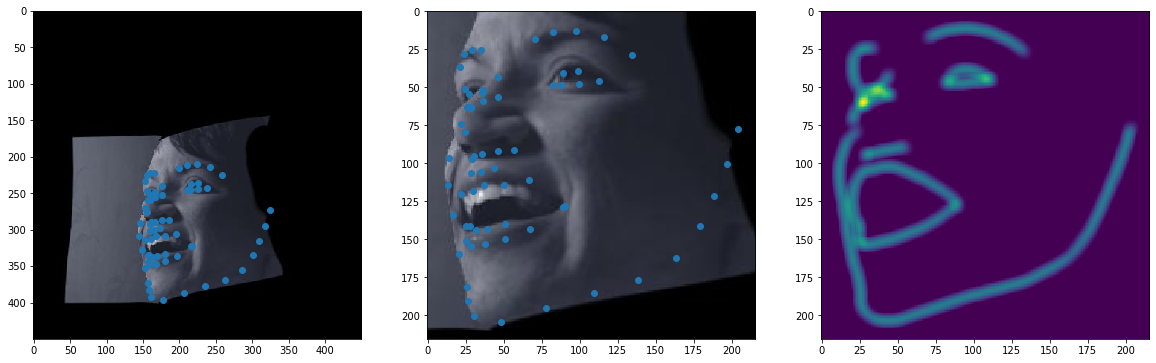

In [73]:
img, pts2d, pts3d, headpose, translations, scale, is_flip = parse_mat(np.random.choice(mat_list))

# face_bbox = get_face_roi2(img, pts2d, 192, 192, 0.0)
face_bbox = get_face_roi3(img, pts2d)
face_bbox = np.array(face_bbox) + [-12, 12, -12, 12]
face = crop_image(img, face_bbox)

landmarks = get_new_landmark(pts2d, face_bbox)
print(face.shape)
h, w, c = face.shape
normed_landmark = landmarks / [w, h]

face = cv2.resize(face, (216, 216))
temp_landmark = normed_landmark * 216

# h, w, c = face.shape
# if h > w:
#     padding = (h - w) // 2
#     face = cv2.copyMakeBorder(face, 0, 0, padding, padding, cv2.BORDER_REPLICATE)
#     landmarks = landmarks + [padding, 0]

# if w > h:
#     padding = (w - h) // 2
#     face = cv2.copyMakeBorder(face, padding, padding, 0, 0, cv2.BORDER_REPLICATE)
#     landmarks = landmarks + [0, padding]

if not is_img_valid(face):
    print('invalid image')

heatmap = np.empty((96, 96, 68))
for i, landmark in enumerate(normed_landmark):
    heatmap[:,:,i] = create_a_heatmap(landmark)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

x, y = np.transpose(pts2d)
axes[0].imshow(img)
axes[0].scatter(x, y)

x, y = np.transpose(temp_landmark)
axes[1].imshow(face)
axes[1].scatter(x, y)

boundary_map = get_boundary_map(temp_landmark.tolist(), face)
boundary_map = np.transpose(boundary_map, [1,2,0])
w, h, c = boundary_map.shape

# normed_img = cv2.normalize(boundary_map, None, 0, 1, cv2.NORM_MINMAX)
input_tensor = np.reshape(boundary_map, (1, w, h, c))
input_tensor = tf.cast(input_tensor, np.float32)
heatmap = tf.nn.depthwise_conv2d(input_tensor, kernel, 
                                 strides=[1, 1, 1, 1], padding='SAME')[0]
axes[2].imshow(np.sum(heatmap, -1))

In [7]:
temp = tf.reshape(tf.cast(heatmap[:,:,0] * 100, tf.uint8), (240, 240, 1))
encoded_jaw = tf.io.encode_jpeg(temp, quality=100).numpy()

In [8]:
w, h, c = heatmap.shape

encoded_boundaries = []
for i in range(c):
    temp = heatmap[:,:,i]
    temp2 = cv2.normalize(temp.numpy(), None, 0, 255, cv2.NORM_MINMAX)
    temp3 = tf.cast(temp2, tf.uint8)
    temp4 = tf.reshape(temp3, (240, 240, 1))
    encoded = tf.io.encode_jpeg(temp4, quality=100).numpy()
    encoded_boundaries.append(encoded)
#     print(len(encoded))

# TFRecord Conversion

In [9]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _bytes_feature2(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def get_features(mat_path):
    img, pts2d, pts3d, headpose, translations, scale, is_flip = parse_mat(np.random.choice(mat_list))

    face_bbox = get_face_roi(img, pts2d, padding=1.0)
    top, bottom, left, right = face_bbox

    w = right - left
    h = bottom - top

    face = crop_image(img, face_bbox)
    
    if not is_img_valid(face):
        return None
    
    landmarks = get_new_landmark(pts2d, face_bbox)

    normed_landmark = landmarks / face.shape[:2]

    # encoding
    encoded_face = tf.io.encode_jpeg(face, quality=100).numpy()
    
    feature = {
        'image': _bytes_feature(encoded_face),
        'landmarks': _float_feature(np.reshape(normed_landmark, (-1)).tolist()),
        'headpose': _float_feature(np.reshape(headpose, (-1)).tolist()),
        'heatmap': _bytes_feature(heatmap)
    }
    
    return feature

In [10]:
write_path = '../../../data-archive/facial_landmarks/300w_lp_k3.tfrecords'
counter = 0

with tf.io.TFRecordWriter(write_path) as writer:
    for i, mat_file in enumerate(mat_list):
        feature = get_features(mat_file)
        
        if feature == None:
            continue
        
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())
        
        if counter % 1000 == 0:
            print(f'{counter}/{len(mat_list)}')
        counter = counter + 1

TypeError: array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., . has type numpy.ndarray, but expected one of: bytes